# **covid-or-healthy**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
!ls

gdrive	sample_data


In [ ]:
#changing the working directory
%cd /content/gdrive/My Drive/Datasets
#Check the present working directory using pwd command

/content/gdrive/My Drive/Datasets


In [ ]:
!ls

apple-or-tomato   covid-or-healthy  pneumonia-or-healhy
banana-or-orange  grape-or-cherry   table-or-glass


In [ ]:
#unzipping the zip files and deleting the zip files
!unzip \*.zip  && rm *.zip

unzip:  cannot find or open *.zip, *.zip.zip or *.zip.ZIP.

No zipfiles found.


In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import os
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils
from keras.models import Sequential
from keras import optimizers
from keras import backend as K
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, ReLU, BatchNormalization,Add, AveragePooling2D, Flatten, Dense
from tensorflow.keras.models import Model
import scipy.misc

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
training_data = []
img_size = 100
assign_dict = {"covid":0, "healthy":1}
directory = "/content/gdrive/My Drive/Datasets/covid-or-healthy/training_set"
for sub_directory in os.listdir(directory):
    if sub_directory == "covid":
        inner_directory = os.path.join(directory,sub_directory)
        for i in os.listdir(inner_directory):
            try:
                img = cv2.imread(os.path.join(inner_directory,i),1)
                img = cv2.resize(img,(100,100))
                training_data.append([img,assign_dict[sub_directory]])
            except:
                pass
    if sub_directory == "healthy":
        inner_directory = os.path.join(directory,sub_directory)
        for i in os.listdir(inner_directory):
            try:
                img = cv2.imread(os.path.join(inner_directory,i),1)
                img = cv2.resize(img,(100,100))
                training_data.append([img,assign_dict[sub_directory]])
            except:
                pass
random.shuffle(training_data)

In [ ]:
len(training_data)

278

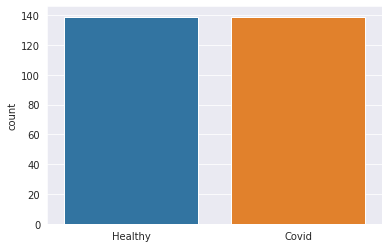

In [ ]:
sns.set_style('darkgrid')
f = []
for status in training_data:
    if(status[1] == 0):
        f.append("Covid")
    else:
        f.append("Healthy")
sns.countplot(f);

In [ ]:
testing_data = []
img_size = 416
assign_dict = {"covid":0, "healthy":1}
directory = "/content/gdrive/My Drive/Datasets/covid-or-healthy/test_set"
for sub_directory in os.listdir(directory):
    if sub_directory == "covid":
        inner_directory = os.path.join(directory,sub_directory)
        for i in os.listdir(inner_directory):
            try:
                img = cv2.imread(os.path.join(inner_directory,i),1)
                img = cv2.resize(img,(100,100))
                testing_data.append([img,assign_dict[sub_directory]])
            except:
                pass
    if sub_directory == "healthy":
        inner_directory = os.path.join(directory,sub_directory)
        for i in os.listdir(inner_directory):
            try:
                img = cv2.imread(os.path.join(inner_directory,i),1)
                img = cv2.resize(img,(100,100))
                testing_data.append([img,assign_dict[sub_directory]])
            except:
                pass

In [ ]:
len(testing_data)

120

In [ ]:
X_train = []
y_train = []
for features,label in training_data:
    X_train.append(features)
    y_train.append(label)

In [ ]:
X_test = []
y_test = []
for features,label in testing_data:
    X_test.append(features)
    y_test.append(label)

In [ ]:
X_train = np.array(X_train)/255.0
X_train = X_train.reshape(-1,100,100,3)
y_train = np.array(y_train)

In [ ]:
X_test = np.array(X_test)/255.0
X_test = X_test.reshape(-1,100,100,3)
y_test = np.array(y_test)

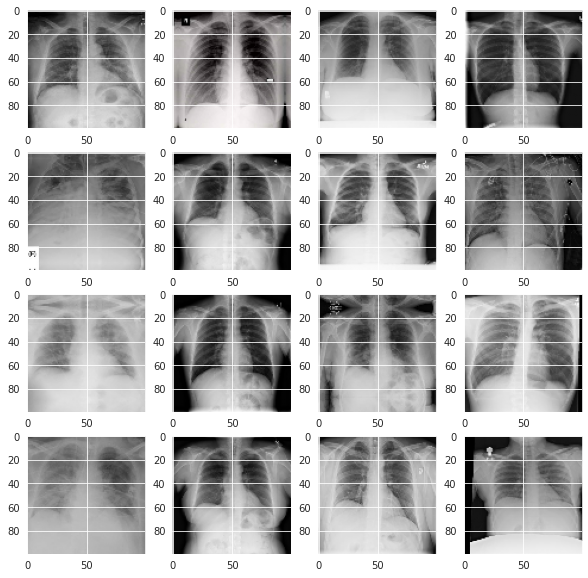

In [ ]:
w=10
h=10
fig=plt.figure(figsize=(10,10))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img = X_train[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(np.squeeze(img))
plt.show()

In [ ]:
def relu_bn(inputs):
    relu = ReLU()(inputs)
    bn = BatchNormalization()(relu)
    return bn

In [ ]:
def residual_block(x, downsample: bool, filters: int, kernel_size: int = 3):
    y = Conv2D(kernel_size=kernel_size,
               strides= (1 if not downsample else 2),
               filters=filters,
               padding="same")(x)
    y = relu_bn(y)
    y = Conv2D(kernel_size=kernel_size,
               strides=1,
               filters=filters,
               padding="same")(y)

    if downsample:
        x = Conv2D(kernel_size=1,
                   strides=2,
                   filters=filters,
                   padding="same")(x)
    out = Add()([x, y])
    out = relu_bn(out)
    return out

In [ ]:
inputs = Input(shape=(100, 100, 3))
num_filters = 32
    
t = BatchNormalization()(inputs)
t = Conv2D(kernel_size=3,
           strides=1,
           filters=32,
           padding="same")(t)
t = relu_bn(t)
    
num_blocks_list = [1, 3, 5, 6, 1]
for i in range(len(num_blocks_list)):
    num_blocks = num_blocks_list[i]
    for j in range(num_blocks):
        t = residual_block(t, downsample=(j==0 and i!=0), filters=num_filters)
    num_filters *= 2
    
t = AveragePooling2D(4)(t)
t = Flatten()(t)
outputs = Dense(1, activation='sigmoid')(t)
    
model = Model(inputs, outputs)

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 100, 100, 3)  12          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 100, 100, 32) 896         batch_normalization[0][0]        
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 100, 100, 32) 0           conv2d[0][0]                     
_______________________________________________________________________________________

In [ ]:
model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

In [ ]:
history=model.fit(X_train,y_train,batch_size = 32,epochs=50,validation_split = 0.1)

Epoch 1/50
8/8 [==============================] - 1s 91ms/step - loss: 0.0251 - accuracy: 0.9920 - val_loss: 2.4857 - val_accuracy: 0.6429
Epoch 2/50
8/8 [==============================] - 1s 87ms/step - loss: 0.0300 - accuracy: 0.9880 - val_loss: 2.8618 - val_accuracy: 0.6429
Epoch 3/50
8/8 [==============================] - 1s 87ms/step - loss: 0.0523 - accuracy: 0.9880 - val_loss: 2.9494 - val_accuracy: 0.6429
Epoch 4/50
8/8 [==============================] - 1s 87ms/step - loss: 0.1562 - accuracy: 0.9640 - val_loss: 2.6222 - val_accuracy: 0.6429
Epoch 5/50
8/8 [==============================] - 1s 88ms/step - loss: 0.1141 - accuracy: 0.9560 - val_loss: 2.3594 - val_accuracy: 0.6429
Epoch 6/50
8/8 [==============================] - 1s 87ms/step - loss: 0.1496 - accuracy: 0.9520 - val_loss: 2.1629 - val_accuracy: 0.6429
Epoch 7/50
8/8 [==============================] - 1s 87ms/step - loss: 0.0449 - accuracy: 0.9880 - val_loss: 3.0438 - val_accuracy: 0.6071
Epoch 8/50
8/8 [===========

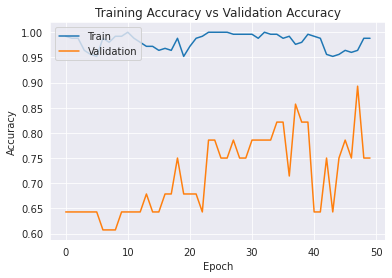

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

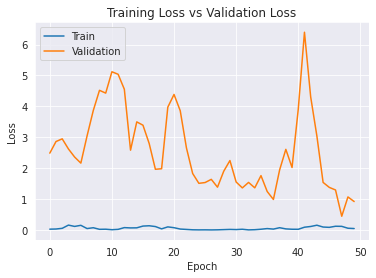

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
score = model.evaluate(X_test, y_test, verbose=0)
print("Loss: " + str(score[0]))
print("Accuracy: " + str(score[1]*100) + "%")

Loss: 1.243671178817749
Accuracy: 80.83333373069763%
